In [15]:
from collections import defaultdict
import copy
from circuit.utils import make_circuitlet
from generate_dataset import gen_cut_dataset
from plot.plot import plot_duration_fidelity, plot_top_ratio, find_error_path, plot_correlation, plot_real_predicted_fidelity
import numpy as np

from upstream import RandomwalkModel
from downstream import FidelityModel
from simulator import NoiseSimulator, get_random_erroneous_pattern
from utils.backend import devide_chip, gen_grid_topology, get_grid_neighbor_info, Backend, topology_to_coupling_map
from utils.backend import default_basis_single_gates, default_basis_two_gates
import pickle
from sklearn.model_selection import train_test_split

In [16]:
size = 6
n_qubits = 18

topology = gen_grid_topology(size)  # 3x3 9 qubits
new_topology = defaultdict(list)
for qubit in topology.keys():
    if qubit < n_qubits:
        for ele in topology[qubit]:
            if ele < n_qubits:
                new_topology[qubit].append(ele)
topology = new_topology
neighbor_info = copy.deepcopy(topology)
coupling_map = topology_to_coupling_map(topology)


backend = Backend(n_qubits=n_qubits, topology=topology, neighbor_info=neighbor_info, basis_single_gates=default_basis_single_gates,
                  basis_two_gates=default_basis_two_gates, divide=False, decoupling=False)


In [19]:


for n_steps  in range(1,2):
    dataset = gen_cut_dataset(n_qubits, topology, neighbor_info, coupling_map, dataset_size = 5000,min_cut_qubit=3,devide_size=5)

    test_dataset = gen_cut_dataset(n_qubits, topology, neighbor_info, coupling_map, dataset_size = 1000,min_cut_qubit=3,devide_size=5)


    print('train dataset size = ', len(dataset))
    print('test dataset size = ', len(test_dataset))
    
    
    upstream_model = RandomwalkModel(
        n_steps, 20, backend=backend, travel_directions=('parallel', 'former'))
    
    upstream_model.train(dataset + test_dataset, multi_process=True,
                         remove_redundancy=n_steps > 1)

    dataset_cut = make_circuitlet(dataset)
    print("cutted", len(dataset_cut))
    
    test_dataset_cut = make_circuitlet(test_dataset)
    print("cutted", len(test_dataset_cut))
    
    all_to_all_backend = Backend(n_qubits=5, topology=None, neighbor_info=neighbor_info, basis_single_gates=default_basis_single_gates,
                  basis_two_gates=default_basis_two_gates, divide=False, decoupling=False)
            
    simulator = NoiseSimulator(all_to_all_backend)
    erroneous_pattern = get_random_erroneous_pattern(
        upstream_model, error_pattern_num_per_device=3)
    
    # 每个subcircuit是单独的NoiseSimulator，backend对应不对
    erroneous_pattern = simulator.get_error_results(
        dataset_cut + test_dataset_cut, upstream_model, multi_process=True, erroneous_pattern=erroneous_pattern)
    upstream_model.erroneous_pattern = erroneous_pattern

    with open(f"upstream_model.pkl", "wb")as f:
        pickle.dump(upstream_model, f)

    train_dataset, validation_dataset = train_test_split(dataset_cut, test_size = .2)
    
    test_dataset = np.array(test_dataset_cut)

    with open(f"dataset.pkl", "wb")as f:
        pickle.dump((train_dataset, validation_dataset, test_dataset), f)




[[0, 1, 5, 6, 10], [7, 11, 12, 13, 17], [2, 3, 4, 8, 9]]
[[2, 3, 4, 8, 9], [0, 1, 5, 6, 11], [7, 12, 13, 14, 17], [10, 15, 16]]
[[2, 3, 4, 8, 9], [10, 11, 15, 16, 17], [0, 1, 5, 6, 7], [12, 13, 14]]
[[10, 11, 15, 16, 17], [0, 1, 2, 3, 7], [4, 8, 9, 12, 13]]
[[3, 4, 8, 9, 14], [0, 1, 2, 6, 7], [10, 11, 15, 16, 17]]
[[10, 11, 15, 16, 17], [2, 6, 7, 8, 12], [0, 1, 5], [3, 4, 9, 13, 14]]


4680 circuit generated
[[1, 5, 6, 7, 11], [10, 12, 15, 16, 17], [3, 8, 9, 13, 14]]
[[2, 6, 7, 8, 12], [3, 4, 9, 13, 14], [0, 1, 5, 10, 11], [15, 16, 17]]
[[4, 8, 9, 13, 14], [0, 5, 10, 11, 15], [1, 2, 3, 6, 7], [12, 16, 17]]
[[2, 6, 7, 8, 12], [5, 10, 11, 16, 17], [3, 4, 9, 13, 14]]
[[0, 5, 10, 11, 15], [1, 2, 3, 4, 8], [7, 12, 13, 16, 17]]
[[3, 4, 8, 9, 14], [7, 11, 12, 13, 17], [0, 5, 10, 15, 16], [1, 2, 6]]
720 circuit generated
train dataset size =  4680
test dataset size =  720
(remote_train pid=3743503) train:0/540, 0th offest
(remote_train pid=3743507) train:0/540, 540th offest
(remote_train pid=3743525) train:0/540, 1620th offest
(remote_train pid=3743482) train:0/540, 1080th offest
(remote_train pid=3743499) train:0/540, 2160th offest
(remote_train pid=3743503) train:100/540, 0th offest
(remote_train pid=3744386) train:0/540, 3240th offest
(remote_train pid=3744376) train:0/540, 2700th offest
(remote_train pid=3744379) train:0/540, 3780th offest
(remote_train pid=3744384) trai

In [21]:

downstream_model = FidelityModel(upstream_model)
downstream_model.train(
    train_dataset,  epoch_num=200)

predicts, reals, durations = [], [], []
for idx, cir in enumerate(test_dataset):
    cir = upstream_model.vectorize(cir)
    if idx % 100 == 0:
        print(idx, "predict finished!")
    predict = downstream_model.predict_fidelity(cir)

    predicts.append(predict)
    reals.append(cir['ground_truth_fidelity'])
    durations.append(cir['duration'])

reals = np.array(reals)
predicts = np.array(predicts)
durations = np.array(durations)

#     # print(predict)
with open(f"error_params_predicts.pkl", "wb")as f:
    pickle.dump((downstream_model, predicts, reals, durations, test_dataset), f)

    
print('average inaccuracy = ', np.abs(predicts - reals).mean())

n_instruction2circuit_infos =  {40: 843, 90: 845, 20: 872, 160: 866, 130: 864, 30: 842, 100: 855, 150: 871, 50: 867, 70: 881, 80: 851, 60: 856, 110: 858, 140: 881, 120: 852}
epoch: 0, 	 epoch loss = 30617.052734375, 	 test loss = 180.73471069335938
epoch: 1, 	 epoch loss = 14808.666015625, 	 test loss = 112.91002655029297
epoch: 2, 	 epoch loss = 9936.5205078125, 	 test loss = 90.98096466064453
epoch: 3, 	 epoch loss = 8332.8603515625, 	 test loss = 83.74571990966797
epoch: 4, 	 epoch loss = 7676.1728515625, 	 test loss = 79.63218688964844
epoch: 5, 	 epoch loss = 7273.4609375, 	 test loss = 76.11280059814453
epoch: 6, 	 epoch loss = 6950.58203125, 	 test loss = 72.79570007324219
epoch: 7, 	 epoch loss = 6669.59814453125, 	 test loss = 69.79713439941406
epoch: 8, 	 epoch loss = 6418.98095703125, 	 test loss = 66.97521209716797
epoch: 9, 	 epoch loss = 6196.60791015625, 	 test loss = 64.52947998046875
epoch: 10, 	 epoch loss = 6000.87158203125, 	 test loss = 62.35596466064453
epoch: 11,

erroneous patterns =  defaultdict(<class 'list'>, {0: ['ry,0-parallel-cz,5,6'], 1: ['ry,1-former-cz,1,6'], 2: ['rx,2-former-cz,1,6', 'rx,2-former-ry,7'], 3: ['rx,3-former-cz,3,4'], 4: ['rx,4-former-ry,9'], 5: ['ry,5-parallel-cz,6,7', 'rx,5-parallel-cz,0,1'], 6: ['rx,6-parallel-rx,11', 'ry,6-parallel-cz,10,11'], 7: ['ry,7-former-cz,12,17', 'ry,7-parallel-ry,12', 'rx,7-former-cz,2,3', 'rx,7-parallel-ry,12', 'rx,7-former-rx,6'], 8: ['rx,8-parallel-rx,9', 'rx,8-former-cz,3,4', 'rx,8-parallel-ry,9', 'rx,8-parallel-ry,3'], 9: ['ry,9-parallel-ry,8'], 10: ['ry,10-former-rx,5'], 11: ['rx,11-former-rx,10', 'rx,11-former-rx,12'], 12: ['ry,12-former-cz,7,12', 'ry,12-parallel-cz,16,17', 'ry,12-former-cz,8,13'], 13: ['rx,13-former-cz,3,8', 'ry,13-former-rx,13', 'rx,13-former-cz,11,12', 'ry,13-former-cz,11,12'], 14: ['ry,14-former-ry,13'], 15: ['rx,15-former-ry,16', 'ry,15-parallel-cz,11,16'], 16: ['rx,16-parallel-cz,10,15', 'ry,16-former-rx,15'], 17: ['rx,17-former-cz,12,17', 'rx,17-parallel-rx,16']

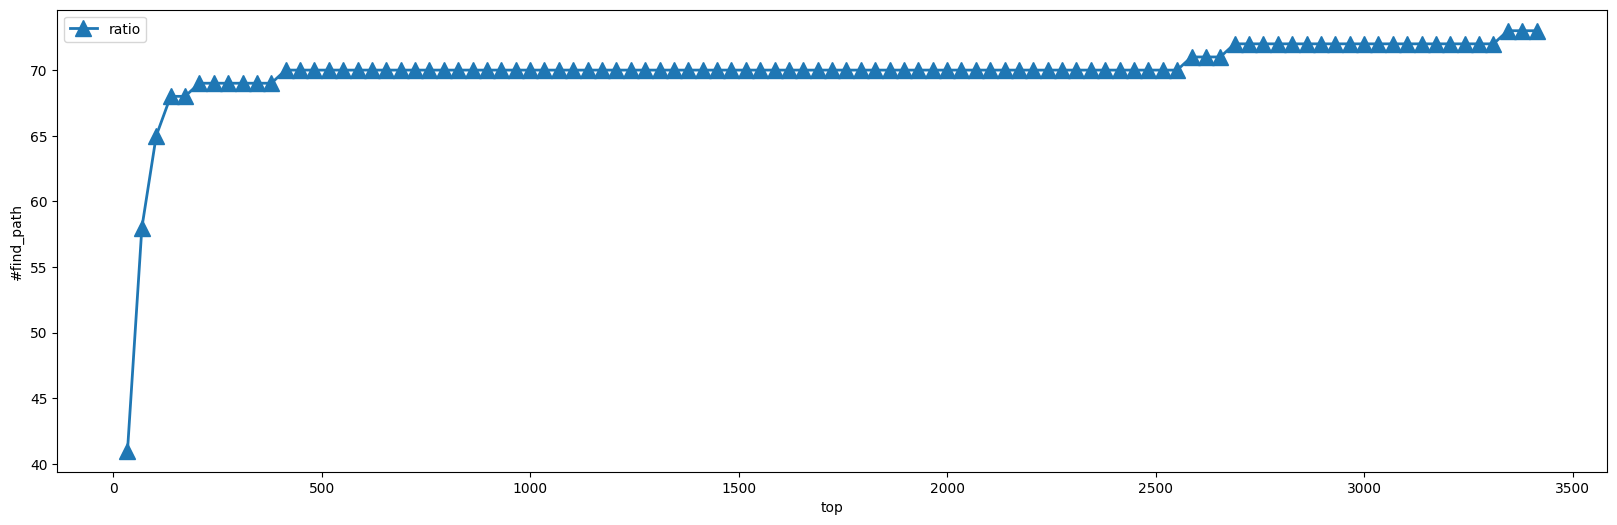

In [22]:
print('erroneous patterns = ', upstream_model.erroneous_pattern)
find_error_path(upstream_model, downstream_model.error_params['gate_params'],name = f"find_ratio.png")


In [23]:
total_dataset = np.concatenate([train_dataset, validation_dataset, test_dataset])
reals_1, durations = [],[]
for cir in total_dataset:
    reals_1.append(cir['ground_truth_fidelity'])
    durations.append(cir['duration'])
reals_1 = np.array(reals_1)

In [24]:

def get_opt_error_path(upstream_model, error_params, name = None):
    error_params = np.array(error_params)
    erroneous_pattern = upstream_model.erroneous_pattern
    
    device_index2device = {} #两比特门与但单比特门映射为一维下标
    for device  in upstream_model.device2path_table.keys():
        device_index = list(upstream_model.device2path_table.keys()).index(device)
        device_index2device[device_index] = device
        
    error_params_path_weight = {} #训练好的参数对应的path及其权重
    error_params_path = {}
    for idx, device_error_param in enumerate(error_params):
        device = device_index2device[idx]
        sort = np.argsort(device_error_param)
        sort = sort[::-1]
        device_error_params_path_weight = []
        device_error_params_path = []
        for i in sort:
            if int(i) in upstream_model.device2reverse_path_table[device].keys():
                path = upstream_model.device2reverse_path_table[device][int(i)]
                if isinstance(path,str):
                    device_error_params_path_weight.append((path,device_error_param[i]))
                    device_error_params_path.append(path)
        error_params_path_weight[device] = device_error_params_path_weight
        error_params_path[device] = device_error_params_path
        
    erroneous_pattern_weight = {} #手动添加的error_path在训练完参数中的排位
    for device, patterns in erroneous_pattern.items():
        device_error_params_path = error_params_path[device]
        device_erroneous_pattern_weight = []
        for pattern in patterns:
            if pattern in device_error_params_path:
                k = device_error_params_path.index(pattern)
                device_erroneous_pattern_weight.append((pattern,k))
        erroneous_pattern_weight[device] = device_erroneous_pattern_weight
    
    new_erroneous_pattern = copy.deepcopy(erroneous_pattern)   
    top = 0.1
    for device, pattern_weights in erroneous_pattern_weight.items():
        path_table_size = len(upstream_model.device2path_table[device].keys())
        for pattern_weight in pattern_weights:
            if  pattern_weight[1] < top * path_table_size:
                if pattern_weight[0] in new_erroneous_pattern[device]:
                    new_erroneous_pattern[device].remove(pattern_weight[0])
                print(device, pattern_weight[0])
        
    return new_erroneous_pattern

erroneous_pattern = get_opt_error_path(upstream_model, downstream_model.error_params['gate_params'])

0 ry,0-parallel-cz,5,6
1 ry,1-former-cz,1,6
2 rx,2-former-cz,1,6
2 rx,2-former-ry,7
3 rx,3-former-cz,3,4
4 rx,4-former-ry,9
5 ry,5-parallel-cz,6,7
5 rx,5-parallel-cz,0,1
6 rx,6-parallel-rx,11
6 ry,6-parallel-cz,10,11
7 ry,7-parallel-ry,12
7 rx,7-former-cz,2,3
7 rx,7-parallel-ry,12
7 rx,7-former-rx,6
8 rx,8-parallel-rx,9
8 rx,8-former-cz,3,4
8 rx,8-parallel-ry,9
8 rx,8-parallel-ry,3
9 ry,9-parallel-ry,8
10 ry,10-former-rx,5
11 rx,11-former-rx,10
11 rx,11-former-rx,12
12 ry,12-former-cz,7,12
12 ry,12-parallel-cz,16,17
12 ry,12-former-cz,8,13
13 rx,13-former-cz,3,8
13 ry,13-former-rx,13
13 rx,13-former-cz,11,12
13 ry,13-former-cz,11,12
14 ry,14-former-ry,13
15 rx,15-former-ry,16
15 ry,15-parallel-cz,11,16
16 rx,16-parallel-cz,10,15
16 ry,16-former-rx,15
17 rx,17-former-cz,12,17
17 rx,17-parallel-rx,16
(4, 9) cz,4,9-former-ry,4
(16, 17) cz,16,17-former-rx,16
(12, 13) cz,12,13-former-rx,11
(8, 9) cz,8,9-parallel-rx,14
(1, 6) cz,1,6-former-ry,2
(1, 6) cz,1,6-former-ry,5
(6, 11) cz,6,11-paral

In [25]:
all_to_all_backend = Backend(n_qubits=5, topology=None, neighbor_info=None, basis_single_gates=default_basis_single_gates,
                basis_two_gates=default_basis_two_gates, divide=False, decoupling=False)    
simulator = NoiseSimulator(all_to_all_backend)

erroneous_pattern = simulator.get_error_results(total_dataset,
                          upstream_model, multi_process=True, erroneous_pattern=erroneous_pattern)
upstream_model.erroneous_pattern = erroneous_pattern

reals_2,durations = [],[]
for cir in total_dataset:
    reals_2.append(cir['ground_truth_fidelity'])
    durations.append(cir['duration'])
reals_2 = np.array(reals_2)

(get_error_result_remote pid=3743932) No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
(get_error_result_remote pid=3743494) No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
(get_error_result_remote pid=3743415) No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
(get_error_result_remote pid=3743510) No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
(get_error_result_remote pid=3743736) No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
(get_error_result_remote pid=3743412) No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
(get_error_result_remote pid=3743481) No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
(get_error_result_remote pid=3744383) No GPU/TPU found, falling back to CPU. (Set T

(get_error_result_remote pid=3744383) 400 finished
(get_error_result_remote pid=3743415) 100 finished
(get_error_result_remote pid=3743369) 650 finished
(get_error_result_remote pid=3744378) 850 finished
(get_error_result_remote pid=3743508) 550 finished
(get_error_result_remote pid=3743666) 1450 finished
(get_error_result_remote pid=3743412) 300 finished
(get_error_result_remote pid=3743932) 50 finished
(get_error_result_remote pid=3743491) 900 finished
(get_error_result_remote pid=3743521) 500 finished
(get_error_result_remote pid=3743492) 950 finished
(get_error_result_remote pid=3743519) 1150 finished
(get_error_result_remote pid=3743653) 1550 finished
(get_error_result_remote pid=3743502) 2750 finished
(get_error_result_remote pid=3743494) 150 finished
(get_error_result_remote pid=3743510) 200 finished
(get_error_result_remote pid=3743483) 750 finished
(get_error_result_remote pid=3743493) 1100 finished
(get_error_result_remote pid=3743484) 1400 finished
(get_error_result_remote p

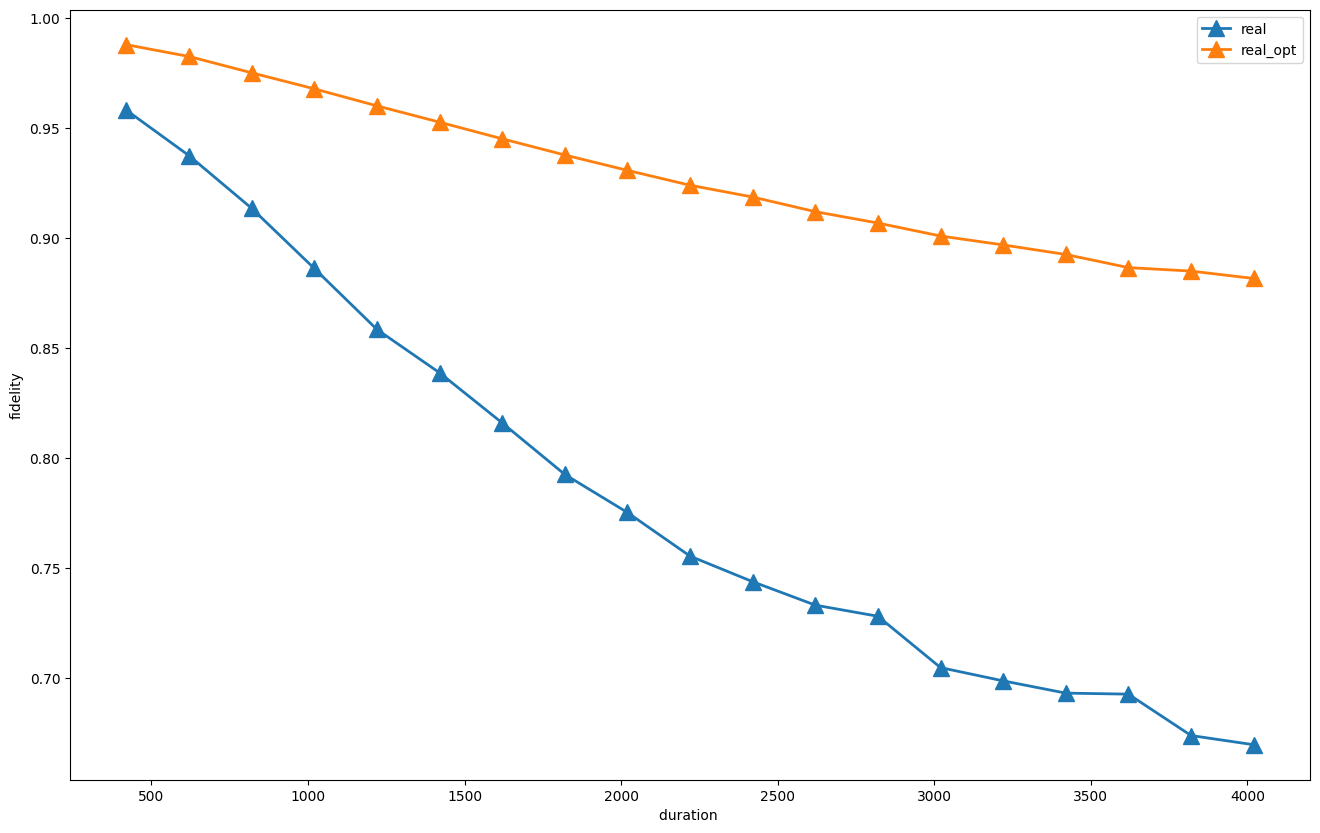

In [26]:
from plot.plot import get_duration2circuit_infos
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(16, 10)) 

durations = np.array(durations)    

duration_X, duration2circuit_index = get_duration2circuit_infos(durations,200,4000)

real_y1,real_y2 = [],[]
for circuit_index in duration2circuit_index:
    real_y1.append(reals_1[circuit_index].mean())
    real_y2.append(reals_2[circuit_index].mean())


axes.plot(duration_X, real_y1 ,markersize = 12,linewidth = 2, label='real',marker = '^' )
axes.plot(duration_X, real_y2 ,markersize = 12,linewidth = 2, label='real_opt',marker = '^' )
axes.set_xlabel('duration ')
axes.set_ylabel('fidelity')
axes.legend() # 添加图例
fig.show()

fig.savefig("remore_error_opt.svg")